In [2]:
from pathlib import Path

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import polars as pl
from area import area
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap
from src.utils.pl_utils import batch_iter
from tqdm import tqdm

%matplotlib widget

In [3]:
PROJECT_ROOT = Path().cwd().parent
PROCESSED_DATA_DIR = PROJECT_ROOT / "data" / "processed"

In [4]:
df = pl.scan_parquet(PROCESSED_DATA_DIR / "LDoGI" / "shard_0.parquet")
df = df.drop("id", "image")
print(df.head().collect())
c = df.select(pl.len()).collect()["len"][0] # count
c

shape: (5, 2)
┌────────────┬────────────┐
│ latitude   ┆ longitude  │
│ ---        ┆ ---        │
│ f64        ┆ f64        │
╞════════════╪════════════╡
│ 41.906     ┆ 12.455     │
│ 48.211072  ┆ 16.36736   │
│ 43.942876  ┆ 12.774091  │
│ 41.339055  ┆ 14.507789  │
│ -23.210269 ┆ -44.693223 │
└────────────┴────────────┘


29999

In [7]:
TAU_MAX = 50
TAU_MIN = 3

In [8]:
def cell_bounds(cell: str):
    west_long = -180
    east_long = 180
    south_lat = -90
    north_lat = 90

    for divide in cell:
        if int(divide) < 2:
            south_lat = (south_lat + north_lat) / 2
        else:
            north_lat = (south_lat + north_lat) / 2

        if int(divide) % 2 == 0:
            east_long = (west_long + east_long) / 2
        else:
            west_long = (west_long + east_long) / 2

    return west_long, east_long, south_lat, north_lat

In [9]:
def is_in_cell(cell: str, lat: float, long: float):
    west_long, east_long, south_lat, north_lat = cell_bounds(cell)
    return west_long <= long <= east_long and south_lat <= lat <= north_lat

In [10]:
print(cell_bounds("0"))
print(cell_bounds("1"))
print(cell_bounds("10"))
print(cell_bounds("11"))
print(cell_bounds("12"))
print(cell_bounds("13"))
print(cell_bounds("121"))

(-180, 0.0, 0.0, 90)
(0.0, 180, 0.0, 90)
(0.0, 90.0, 45.0, 90)
(90.0, 180, 45.0, 90)
(0.0, 90.0, 0.0, 45.0)
(90.0, 180, 0.0, 45.0)
(45.0, 90.0, 22.5, 45.0)


In [11]:
print(is_in_cell("10", 054.76098032609564, 10.87077929120943))

True


In [12]:
# create enum of cell states
class CellState:
    STOPPED = 0
    EVALUATING = 1
    ACTIVE = 2

In [13]:
class QuadTree(nx.DiGraph):
    def __init__(self, incoming_graph_data=None, **attr):
        super().__init__(incoming_graph_data, **attr)
        self.add_node("", state=CellState.EVALUATING)

    def expand(self):
        for node_id in list(self.nodes):
            node = self.nodes[node_id]
            if node["state"] == CellState.EVALUATING:
                node["state"] = CellState.STOPPED
                for i in range(4):
                    self.add_node(f"{node_id}{i}", state=CellState.EVALUATING)
                    self.add_edge(node_id, f"{node_id}{i}")

    def evaluate_cells(self, df: pl.LazyFrame, min_count: int, max_count: int):
        for node_id in list(self.nodes):
            node = self.nodes[node_id]
            if not node["state"] == CellState.EVALUATING:
                continue

            west_long, east_long, south_lat, north_lat = cell_bounds(node_id)
            filtered_df = df.filter(
                (pl.col("latitude") < north_lat)
                & (pl.col("latitude") > south_lat)
                & (pl.col("longitude") < east_long)
                & (pl.col("longitude") > west_long)
            )

            count_in_cell = filtered_df.count().collect()["latitude"][0]
            # obj = {
            #     "type": "Polygon",
            #     "coordinates": [
            #         [[west_long, south_lat], [west_long, north_lat], [east_long, north_lat], [east_long, south_lat]]
            #     ],
            # }
            # a = area(obj) / 10**6
            # density = count_in_cell / a
            # print(f"{node_id} density: {density} count: {count_in_cell} area: {a}")
            if count_in_cell > min_count:
                # if count_in_cell == 0 or (density < min_density and a < 100):
                #     print(f"dropped: {node_id} with {count_in_cell} points over {a} km^2")
                #     node["state"] = CellState.STOPPED
                # else:
                #     node["state"] = CellState.ACTIVE
                if count_in_cell < max_count:
                    node["state"] = CellState.ACTIVE
            else:
                node["state"] = CellState.STOPPED

    def is_evaluating(self):
        return CellState.EVALUATING in [node["state"] for node in self.nodes.values()]

In [48]:
G = QuadTree()
# G.add_node("root", stop=True)
# G.add_nodes_from([(str(i), {"stop": False}) for i in range(4)])
# G.add_edge("root", "0")
# G.add_edge("root", "1")
# G.add_edge("root", "2")
# G.add_edge("root", "3")
subax1 = plt.subplot(121)
subax1.clear()
nx.draw(G, with_labels=True, font_weight='bold')

# subax2 = plt.subplot(122)
# subax2.clear()
t = tqdm(desc="Building QuadTree") # Initialise
while G.is_evaluating():
    G.expand()
    G.evaluate_cells(df, 10, 100)
    t.update(nx.dag_longest_path_length(G))
# nx.draw(G, with_labels=True, font_weight='bold')
t.close()

print(G)
# subax2 = plt.subplot(122)
# subax2.clear()
# nx.draw(G, with_labels=True, font_weight='bold')
# plt.show()

Building QuadTree: 0it [01:14, ?it/s]
Building QuadTree: 105it [00:01, 55.16it/s]

QuadTree with 1625 nodes and 1624 edges


In [14]:
def draw_screen_poly(lats, lons, m, res):
    # Convert to linspace
    lats_linspace = np.linspace(lats[0], lats[1], res)
    lons_linspace = np.linspace(lons[0], lons[1], res)

    # Define the edge points' coordinates
    west_edge_lats = lats_linspace
    west_edge_lons = [lons_linspace[0]] * res
    north_edge_lats = [lats_linspace[-1]] * res
    north_edge_lons = lons_linspace
    east_edge_lats = lats_linspace[::-1]
    east_edge_lons = [lons_linspace[-1]] * res
    south_edge_lats = [lats_linspace[0]] * res
    south_edge_lons = lons_linspace[::-1]

    # Convert to map projection
    geo_rect_lats = np.concatenate(
        [
            west_edge_lats,
            north_edge_lats,
            east_edge_lats,
            south_edge_lats,
        ]
    )
    geo_rect_lons = np.concatenate(
        [
            west_edge_lons,
            north_edge_lons,
            east_edge_lons,
            south_edge_lons,
        ]
    )
    x, y = m(geo_rect_lons, geo_rect_lats)

    xy = zip(x, y)
    # get random color
    colors = ["green", "blue", "red", "yellow", "purple", "orange", "black"]
    facecolor = np.random.choice(colors)

    poly = Polygon(list(xy), facecolor=facecolor, alpha=0.4)
    plt.gca().add_patch(poly)

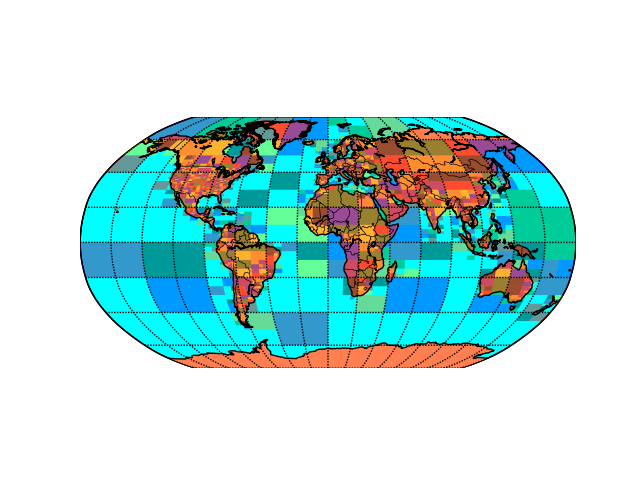

In [15]:
# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.



fig, ax = plt.subplots()  # a figure with a single Axes
m = Basemap(projection="robin", lon_0=0, resolution="c")


# Draw coastlines and countries
m.drawcoastlines()
m.drawcountries()
# m = Basemap(projection="robin", lon_0=0, resolution="c")
m.fillcontinents(color="coral", lake_color="aqua")
# # draw parallels and meridians.
m.drawparallels(np.arange(-90.0, 120.0, 22.5))
m.drawmeridians(np.arange(0.0, 360.0, 22.5))
m.drawmapboundary(fill_color="aqua")


res = 10
for node, data in [n for n in G.nodes.data() if n[1]["state"] == CellState.ACTIVE]:

    west_long, east_long, south_lat, north_lat = cell_bounds(node)




    draw_screen_poly((south_lat, north_lat), (west_long, east_long), m, res)
# lats = np.linspace(south_lat, north_lat, res)
# lons = np.linspace(west_long, east_long, res)
# south_edge_x = lats
# south_edge_y = [lons[0]] * res
# east_edge_x = [lats[-1]] * res
# east_edge_y = lons
# north_edge_x = lats[::-1]
# north_edge_y = [lons[-1]] * res
# west_edge_x = [lats[0]] * res
# west_edge_y = lons[::-1]

# xs = np.concatenate([south_edge_x[:-1], east_edge_x[:-1], north_edge_x[:-1], west_edge_x[:-1]])
# ys = np.concatenate([south_edge_y[:-1], east_edge_y[:-1], north_edge_y[:-1], west_edge_y[:-1]])
# x, y = m(ys, xs)

# xy = zip(x, y)
# poly = Polygon(list(xy), facecolor="blue", alpha=0.4)
# plt.gca().add_patch(poly)
# m.contourf(
#     [west_long, west_long, east_long, east_long, west_long],
#     [south_lat, north_lat, north_lat, south_lat, south_lat], [[0,0]],
#     latlon=True,
#     color="blue",
# )  # plot a blue dot there

# print("iterating over graph")
# for node in tqdm(G.nodes):
#     west_long, east_long, south_lat, north_lat = cell_bounds(node)

#     m.plot(
#         [west_long, west_long, east_long, east_long],
#         [south_lat, north_lat, south_lat, north_lat],
#         "b",
#         latlon=True,
#         fillstyle="full",
#     )  # plot a blue dot there

In [16]:
nx.write_gml(G, "test.gml")

In [5]:
G = nx.read_gml(PROCESSED_DATA_DIR / "quadtrees" / "whole.gml")